In [110]:
import numpy as np
import hypertools as hyp
import matplotlib.pyplot as plt

def add_arrows(axes, x, y, **kwargs):

    # spacing of arrows
    aspace = .05 # good value for scale of 1
    aspace *= scale

    # r is the distance spanned between pairs of points
    r = [0]
    for i in range(1,len(x)):
        dx = x[i]-x[i-1]
        dy = y[i]-y[i-1]
        r.append(np.sqrt(dx*dx+dy*dy))
    r = np.array(r)

    # rtot is a cumulative sum of r, it's used to save time
    rtot = []
    for i in range(len(r)):
        rtot.append(r[0:i].sum())
    rtot.append(r.sum())

    arrowData = [] # will hold tuples of x,y,theta for each arrow
    arrowPos = 0 # current point on walk along data
    rcount = 1 
    while arrowPos < r.sum():
        x1,x2 = x[rcount-1],x[rcount]
        y1,y2 = y[rcount-1],y[rcount]
        da = arrowPos-rtot[rcount] 
        theta = np.arctan2((x2-x1),(y2-y1))
        ax = np.sin(theta)*da+x1
        ay = np.cos(theta)*da+y1
        arrowData.append((ax,ay,theta))
        arrowPos+=aspace
        while arrowPos > rtot[rcount+1]: 
            rcount+=1
            if arrowPos > rtot[-1]:
                break

    # could be done in above block if you want
    for ax,ay,theta in arrowData:
        # use aspace as a guide for size and length of things
        # scaling factors were chosen by experimenting a bit
        axes.arrow(ax,ay,
                   np.sin(theta)*aspace/10,np.cos(theta)*aspace/10, 
                   head_width=aspace/3, **kwargs)
        
cmap = plt.cm.Spectral
%matplotlib inline

## Load data

In [124]:
matches = np.load('../data/labels.npy')
video_embedding = np.load('../data/video_embedding.npy')
avg_recall_embedding = np.load('../data/avg_recall_embedding.npy')

## Compute transition matrix

In [121]:
transition_mtx = np.zeros((34, 34))
for sub in matches:
    for i in range(len(sub)-1):
        transition_mtx[sub[i], sub[i+1]]+=1
norm_transition_mtx = np.array(list(map(lambda x: x/x.sum(), transition_mtx)))

## Plot figure

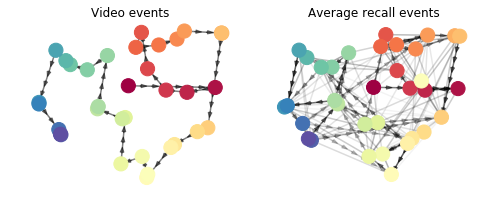

In [123]:
fig, axarr = plt.subplots(1, 2, figsize=(8, 3))
axarr[0].scatter(video_embedding[:, 0], video_embedding[:, 1], c=range(34), cmap=cmap, s=200, zorder=2)
axarr[0].plot(video_embedding[:, 0], video_embedding[:, 1], zorder=1, c='k', alpha=.5)
add_arrows(axarr[0], video_embedding[:, 0], video_embedding[:, 1], zorder=0, alpha=.5, color='k', fill=True)
axarr[0].axis('off')
axarr[0].set_title('Video events')
for i in range(norm_transition_mtx.shape[0]):
    for j in range(norm_transition_mtx.shape[1]):
        if norm_transition_mtx[i, j]>0:
            axarr[1].plot([avg_recall_embedding[i, 0], avg_recall_embedding[j, 0]], 
                          [avg_recall_embedding[i, 1], avg_recall_embedding[j, 1]], 
                          zorder=1, c='k', alpha=norm_transition_mtx[i, j])
        if norm_transition_mtx[i, j]==max(norm_transition_mtx[i, :]):
            add_arrows(axarr[1], [avg_recall_embedding[i, 0], avg_recall_embedding[j, 0]],
                       [avg_recall_embedding[i, 1], avg_recall_embedding[j, 1]],
                       zorder=1, alpha=norm_transition_mtx[i, j], color='k')
axarr[1].scatter(avg_recall_embedding[:, 0], avg_recall_embedding[:, 1], 
                 c=range(34), cmap=cmap, s=200, zorder=2)
axarr[1].axis('off')
axarr[1].set_xlim(axarr[0].get_xlim())
axarr[1].set_ylim(axarr[0].get_ylim())
axarr[1].set_title('Average recall events')
# plt.savefig('../figures/avg_traj_with_transitions_arrows.pdf')
plt.show()
